In [1]:
import matplotlib.pyplot as plt
import numpy as np

from beliefppg import infer_hr, infer_hr_uncertainty

2024-08-28 17:14:07.694621: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-28 17:14:07.694643: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-28 17:14:07.694660: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-28 17:14:07.699088: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
sampling_rate = 128  # Hz (sampling rate of accelerometer and ppg sensor)

# Load data item containing the PPG, HR, and IMU signals --- challenging custom dataset
data = np.load('Data/example.npy', allow_pickle=True).item()

ppg = data['PPG head'].reshape((-1,1)) # reshape ppg to (n_samples, n_channels)
IMU_X = data['IMU X head']
IMU_Y = data['IMU Y head']
IMU_Z = data['IMU Z head']

acc = np.stack([IMU_X,IMU_X, IMU_Z], axis=-1)

GT_hr = data['ground truth HR'] # reported for every 30 seconds in bpm

## QUICK START

In [3]:
hr, idxs = infer_hr(ppg=ppg, ppg_freq=sampling_rate, acc=acc, acc_freq=sampling_rate)

mean_hr = [np.mean(hr[i:i+15]) for i in range(0, len(hr), 15)] # ground truth HR is reported every 30 seconds, hr is reported every 2 seconds
mean_idxs = [np.mean(idxs[i:i+15]) for i in range(0, len(hr), 15)]

hr_wo_acc, idxs_wo_acc = infer_hr(ppg=ppg, ppg_freq=sampling_rate, acc=None, acc_freq=None) # infer HR without using the accelerometer
mean_hr_wo_acc = [np.mean(hr_wo_acc[i:i+15]) for i in range(0, len(hr_wo_acc), 15)]

2024-08-28 17:14:09.680051: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-08-28 17:14:09.680071: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: pstreliPC
2024-08-28 17:14:09.680075: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: pstreliPC
2024-08-28 17:14:09.680106: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 520.61.5
2024-08-28 17:14:09.680117: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 520.61.5
2024-08-28 17:14:09.680121: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:309] kernel version seems to match DSO: 520.61.5


48/48 [==============================] - 6s 108ms/step


Text(0.5, 1.0, 'Estimated HR without Accelerometer')

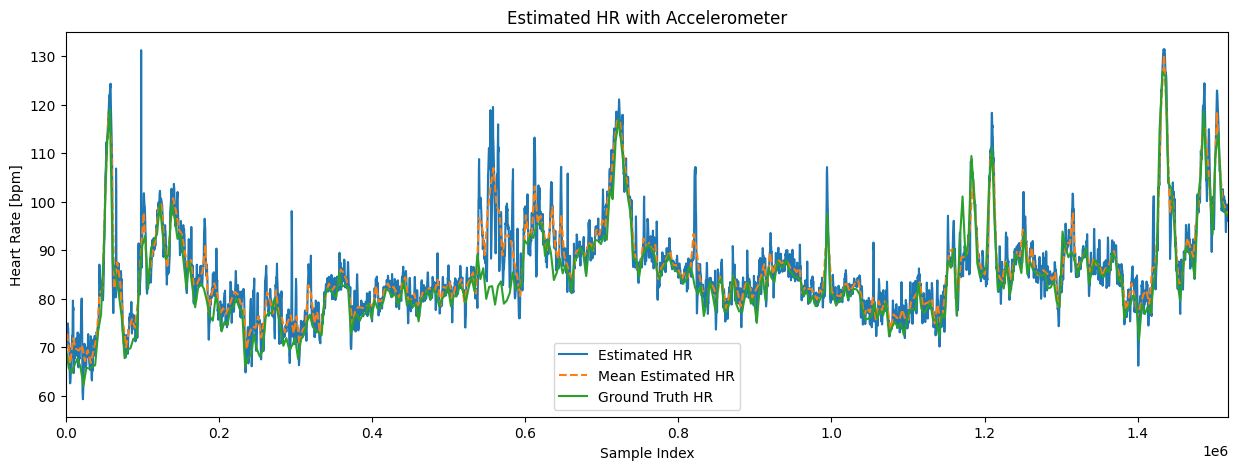

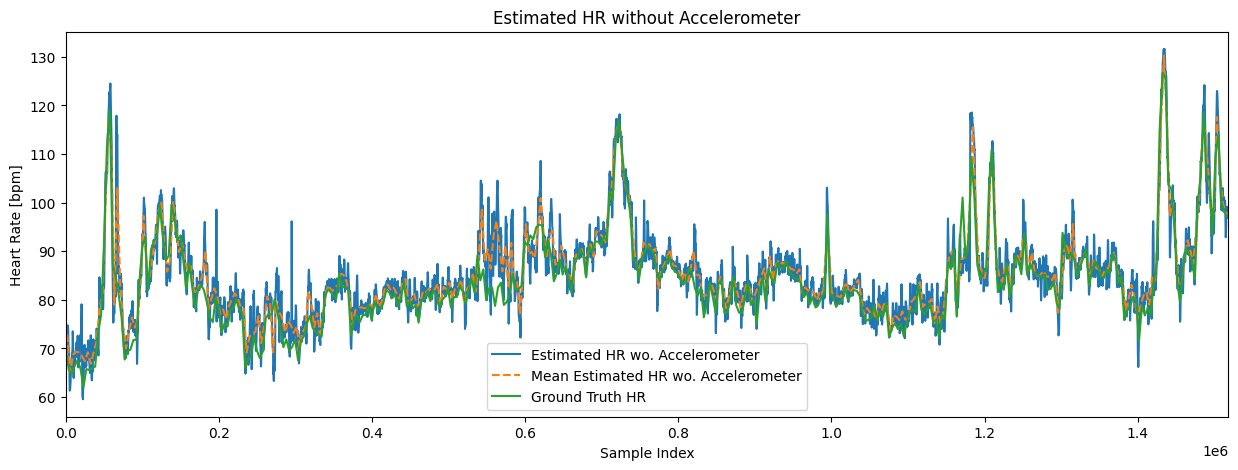

In [4]:
plt.figure(figsize=(15,5))
plt.plot(idxs, hr, c='C0', label='Estimated HR')
plt.plot(mean_idxs, mean_hr, c='C1', linestyle='--', label='Mean Estimated HR')
plt.plot(np.arange(0, len(GT_hr)*30*sampling_rate, 30*sampling_rate), GT_hr, c='C2', label='Ground Truth HR')
plt.xlabel('Sample Index')
plt.ylabel('Heart Rate [bpm]')
plt.legend()
plt.xlim((0, np.max(idxs)))
plt.title('Estimated HR with Accelerometer')

plt.figure(figsize=(15,5))
plt.plot(idxs, hr_wo_acc, c='C0', label='Estimated HR wo. Accelerometer')
plt.plot(mean_idxs, mean_hr_wo_acc, c='C1', linestyle='--', label='Mean Estimated HR wo. Accelerometer')
plt.plot(np.arange(0, len(GT_hr)*30*sampling_rate, 30*sampling_rate), GT_hr, c='C2', label='Ground Truth HR')
plt.xlabel('Sample Index')
plt.ylabel('Heart Rate [bpm]')
plt.legend()
plt.xlim((0, np.max(idxs)))
plt.title('Estimated HR without Accelerometer')

## WITH TIME BACKBONE --- SUMPRODUCT / BELIEF PROPAGATION

In [5]:
hr, std, time_intervals = infer_hr_uncertainty(ppg=ppg, ppg_freq=sampling_rate, acc=acc, acc_freq=sampling_rate, decoding='sumproduct', use_time_backbone=True, uncertainty="std")
ts = np.mean(time_intervals, axis=-1)

mean_hr = [np.mean(hr[i:i+15]) for i in range(0, len(hr), 15)] # ground truth HR is reported every 30 seconds, hr is reported every 2 seconds
mean_ts = [np.mean([time_intervals[i:i+15][0,0], time_intervals[i:i+15][-1,-1]]) for i in range(0, len(hr), 15)]

hr_wo_acc, std_wo_acc, time_intervals_wo_acc = infer_hr_uncertainty(ppg=ppg, ppg_freq=sampling_rate, acc=None, acc_freq=None, decoding='sumproduct', use_time_backbone=True, uncertainty="std") # infer HR without using the accelerometer
mean_hr_wo_acc = [np.mean(hr_wo_acc[i:i+15]) for i in range(0, len(hr_wo_acc), 15)]


48/48 [==============================] - 6s 107ms/step


Text(0.5, 1.0, 'Estimated HR without Accelerometer')

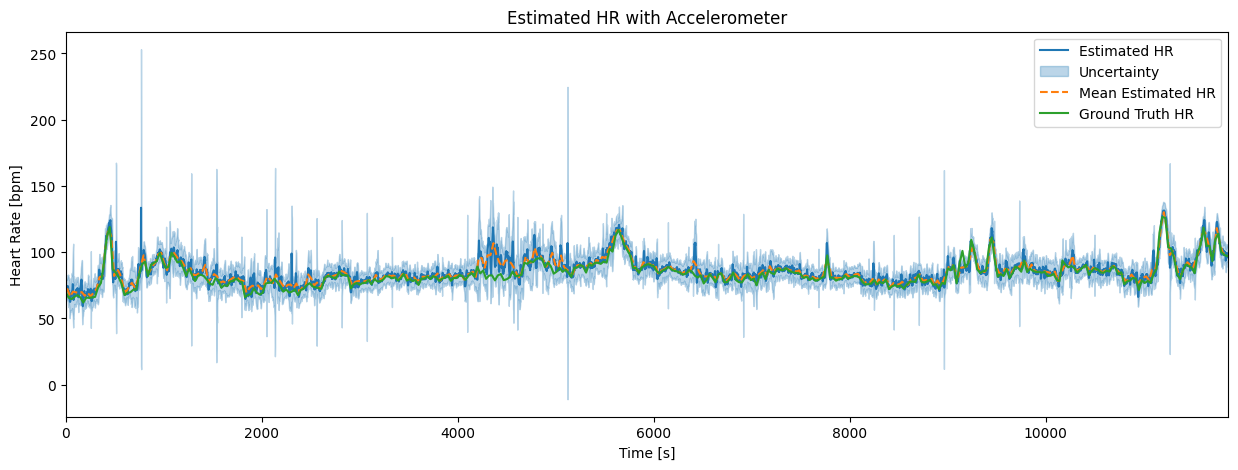

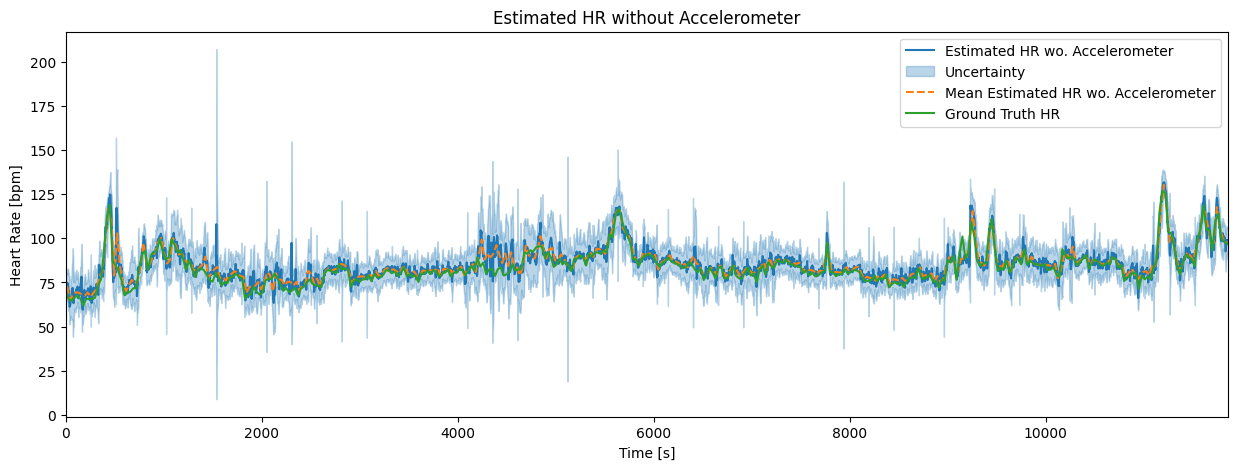

In [6]:
plt.figure(figsize=(15,5))
plt.plot(ts, hr, c='C0', label='Estimated HR')
plt.fill_between(ts, hr-3*std, hr+3*std, color='C0', alpha=0.3, label='Uncertainty')
plt.plot(mean_ts, mean_hr, c='C1', linestyle='--', label='Mean Estimated HR')
plt.plot(np.arange(0, len(GT_hr)*30, 30), GT_hr, c='C2', label='Ground Truth HR')
plt.xlabel('Time [s]')
plt.ylabel('Heart Rate [bpm]')
plt.legend()
plt.xlim((0, np.max(ts)))
plt.title('Estimated HR with Accelerometer')

plt.figure(figsize=(15,5))
plt.plot(ts, hr_wo_acc, c='C0', label='Estimated HR wo. Accelerometer')
plt.fill_between(ts, hr_wo_acc-3*std_wo_acc, hr_wo_acc+3*std_wo_acc, color='C0', alpha=0.3, label='Uncertainty')
plt.plot(mean_ts, mean_hr_wo_acc, c='C1', linestyle='--', label='Mean Estimated HR wo. Accelerometer')
plt.plot(np.arange(0, len(GT_hr)*30, 30), GT_hr, c='C2', label='Ground Truth HR')
plt.xlabel('Time [s]')
plt.ylabel('Heart Rate [bpm]')
plt.legend()
plt.xlim((0, np.max(ts)))
plt.title('Estimated HR without Accelerometer')

## WITH TIME BACKBONE --- VITERBI

In [7]:
hr, uncertainty, time_intervals = infer_hr_uncertainty(ppg=ppg, ppg_freq=sampling_rate, acc=acc, acc_freq=sampling_rate, decoding='viterbi', use_time_backbone=True)
ts = np.mean(time_intervals, axis=-1)

mean_hr = [np.mean(hr[i:i+15]) for i in range(0, len(hr), 15)] # ground truth HR is reported every 30 seconds, hr is reported every 2 seconds
mean_ts = [np.mean([time_intervals[i:i+15][0,0], time_intervals[i:i+15][-1,-1]]) for i in range(0, len(hr), 15)]

48/48 [==============================] - 6s 106ms/step


(0.0, 11861.0)

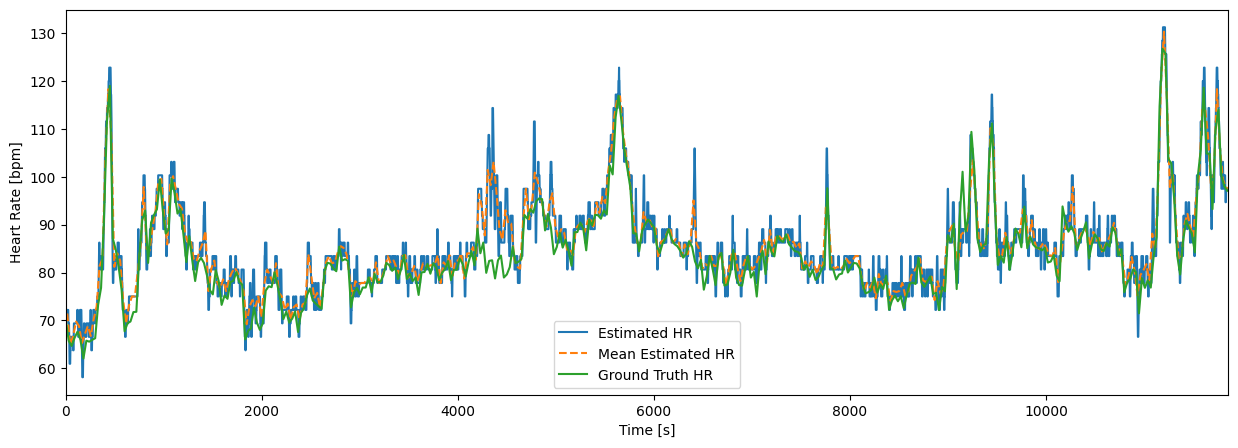

In [8]:
plt.figure(figsize=(15,5))
plt.plot(ts, hr, c='C0', label='Estimated HR')
plt.plot(mean_ts, mean_hr, c='C1', linestyle='--', label='Mean Estimated HR')
plt.plot(np.arange(0, len(GT_hr)*30, 30), GT_hr, c='C2', label='Ground Truth HR')
plt.xlabel('Time [s]')
plt.ylabel('Heart Rate [bpm]')
plt.legend()
plt.xlim((0, np.max(ts)))

## WITHOUT TIME BACKBONE --- SUMPRODUCT

In [9]:
hr, std, time_intervals = infer_hr_uncertainty(ppg=ppg, ppg_freq=sampling_rate, acc=acc, acc_freq=sampling_rate, decoding='sumproduct', use_time_backbone=False, uncertainty="std")
ts = np.mean(time_intervals, axis=-1)

mean_hr = [np.mean(hr[i:i+15]) for i in range(0, len(hr), 15)] # ground truth HR is reported every 30 seconds, hr is reported every 2 seconds
mean_ts = [np.mean([time_intervals[i:i+15][0,0], time_intervals[i:i+15][-1,-1]]) for i in range(0, len(hr), 15)]

48/48 [==============================] - 5s 106ms/step


(0.0, 11861.0)

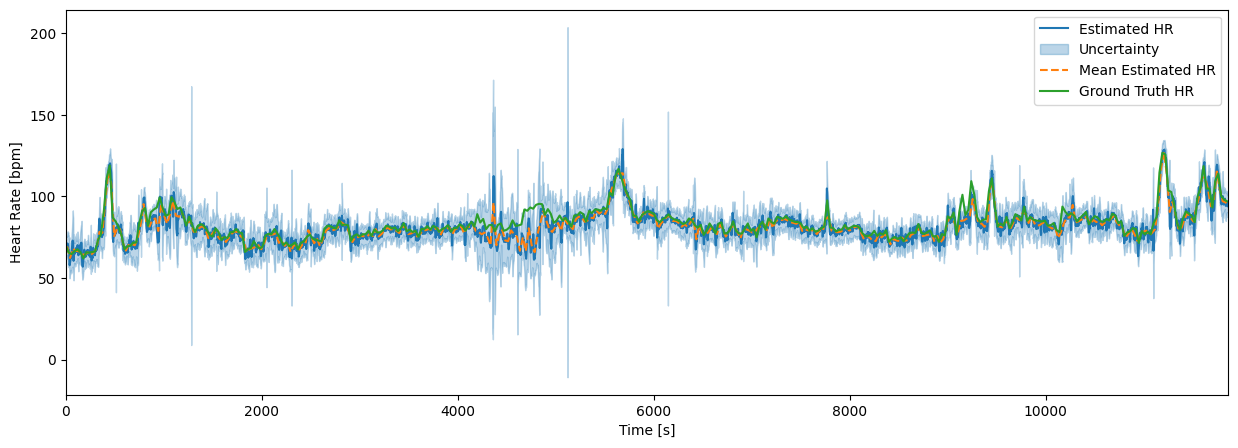

In [10]:
plt.figure(figsize=(15,5))
plt.plot(ts, hr, c='C0', label='Estimated HR')
plt.fill_between(ts, hr -3* std, hr+3*std, color='C0', alpha=0.3, label='Uncertainty')
plt.plot(mean_ts, mean_hr, c='C1', linestyle='--', label='Mean Estimated HR')
plt.plot(np.arange(0, len(GT_hr)*30, 30), GT_hr, c='C2', label='Ground Truth HR')
plt.xlabel('Time [s]')
plt.ylabel('Heart Rate [bpm]')
plt.legend()
plt.xlim((0, np.max(ts)))

## WITHOUT TIME BACKBONE --- VITERBI

In [11]:
hr, uncertainty, time_intervals = infer_hr_uncertainty(ppg=ppg, ppg_freq=sampling_rate, acc=acc, acc_freq=sampling_rate, decoding='viterbi', use_time_backbone=False)
ts = np.mean(time_intervals, axis=-1)

mean_hr = [np.mean(hr[i:i+15]) for i in range(0, len(hr), 15)] # ground truth HR is reported every 30 seconds, hr is reported every 2 seconds
mean_ts = [np.mean([time_intervals[i:i+15][0,0], time_intervals[i:i+15][-1,-1]]) for i in range(0, len(hr), 15)]

48/48 [==============================] - 6s 108ms/step


(0.0, 11861.0)

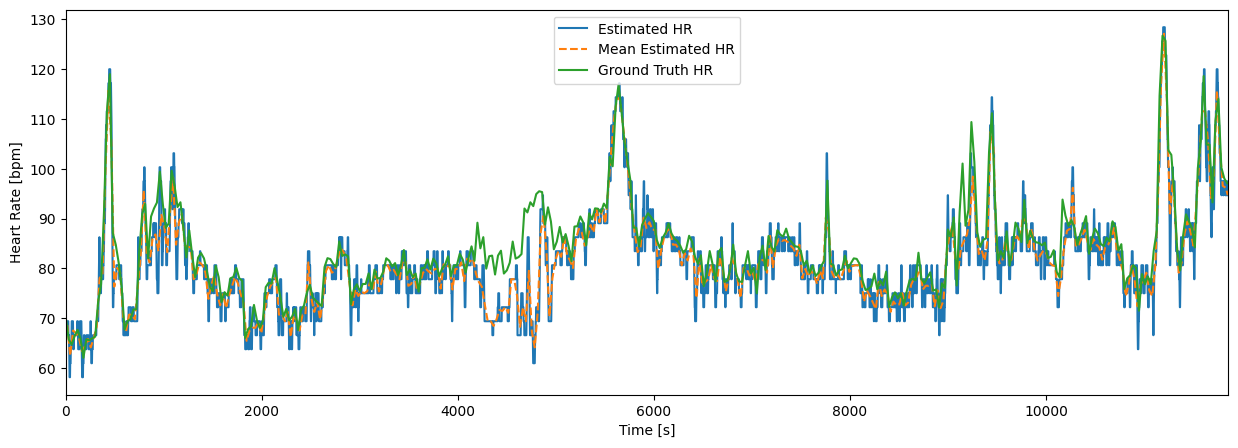

In [12]:
plt.figure(figsize=(15,5))
plt.plot(ts, hr, c='C0', label='Estimated HR')
plt.plot(mean_ts, mean_hr, c='C1', linestyle='--', label='Mean Estimated HR')
plt.plot(np.arange(0, len(GT_hr)*30, 30), GT_hr, c='C2', label='Ground Truth HR')
plt.xlabel('Time [s]')
plt.ylabel('Heart Rate [bpm]')
plt.legend()
plt.xlim((0, np.max(ts)))